In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timesteps = 50
dt = 1e-3
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
        "threshold": 1.0,
        "i_offset": 0.0,
        "reset": "reset_to_v_reset",
        "dt": dt,
        "tau_mem": tau_mem,
        "tau_syn": tau_syn,
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
dims = [50, 1, 10]
np.random.seed(0)
spike_times = {
    n: np.where(
        np.random.poisson(lam=0.1, size=(timesteps)).clip(0, 1).astype(int)
    )[0].tolist()
    for n in range(dims[0])
}
print(spike_times)
input_spikes = np.zeros((timesteps, 1, dims[0]))
for n, times in spike_times.items() : 
    input_spikes[times, 0, n] = 1

input_spikes = torch.from_numpy(input_spikes).float().to(device)

{0: [8, 12, 18, 24, 34, 47], 1: [14, 15, 31, 44, 49], 2: [11, 35, 36], 3: [0, 12, 18, 26, 42], 4: [6, 8, 30, 36, 40, 46, 48, 49], 5: [9, 20], 6: [19, 28, 45, 49], 7: [1, 10, 15, 16, 32, 36], 8: [1, 5, 7, 9, 25, 27, 29, 38], 9: [4, 25, 36, 40], 10: [7, 9, 10, 11, 15, 19, 28, 33, 36, 48], 11: [4, 8, 18, 23, 39], 12: [17, 49], 13: [4, 17, 23, 26, 38, 39, 44], 14: [13, 23, 41], 15: [1, 18, 23, 27, 39], 16: [15, 21], 17: [9, 29, 30, 35, 38], 18: [0, 11, 24, 28, 31, 46], 19: [13, 16, 21, 26, 30, 38, 41, 43], 20: [6, 9, 11, 16, 19, 37], 21: [0, 4, 7, 9, 15, 17, 26, 44, 45], 22: [12, 17, 21, 26, 30, 49], 23: [4, 10, 16, 27, 28, 34, 36, 38, 48], 24: [20, 25, 45, 47], 25: [3, 25, 26, 33, 41, 47], 26: [1, 2, 24, 25, 33, 42, 45], 27: [5, 10, 13, 14, 19, 32, 38], 28: [12, 16, 25, 26, 28, 39, 48], 29: [16, 26, 43], 30: [8, 26, 37], 31: [22, 29, 45], 32: [7, 13, 22, 27, 32, 44, 46], 33: [8, 11, 12, 19, 34, 41], 34: [4, 21, 24, 36, 43], 35: [0, 3, 9, 10, 19], 36: [19, 25, 31, 35, 36], 37: [19, 25, 35,

In [5]:
from eventprop.models import SNN

In [6]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "mu": 1.,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type" : "eventprop"
}


In [7]:
eventprop_model = SNN(dims, **model_config).to(device)
layers = eventprop_model.layers
w_hidden = np.random.normal(1/np.sqrt(dims[0]), 1/np.sqrt(dims[0]), size=(dims[0], dims[1])) * 2
w_out = np.random.normal(1/np.sqrt(dims[1]), 1/np.sqrt(dims[1]), size=(dims[1], dims[2])) * 4


In [8]:
layers[0].weight.data = torch.from_numpy(w_hidden).T.float()
layers[1].weight.data = torch.from_numpy(w_out).T.float()

In [9]:
packs = []
input = input_spikes	
for layer in layers : 
    print(input.shape)
    pack, _ = layer.manual_forward(input)
    packs.append(pack)
    input = pack[-1]
    


torch.Size([50, 1, 50])
torch.Size([50, 1, 1])


In [10]:
(inputs, Vs, Is, all_out_spikes) = list(zip(*packs))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [11]:
all_spike_times = {}
for layer_id, (out_spikes, dim) in enumerate(zip(all_out_spikes, dims[1:])) : 
    all_spike_times[layer_id] = {}
    
    spike_times = torch.where(out_spikes[:, 0])
    spike_times = {
        n : spike_times[0][spike_times[1] == n].cpu().data.numpy() for n in range(dim)
    }
    spike_times
    first_spike_times = {
        n : spike_times[n][0] if len(spike_times[n]) > 0 else -1 for n in range(dim)
    }
    first_spikes_only = torch.zeros_like(out_spikes)
    for n in range(dim) : 
        if first_spike_times[n] > 0 : 
            first_spikes_only[first_spike_times[n], 0, n] = 1
    all_spike_times[layer_id]["all"] = spike_times
    all_spike_times[layer_id]["first"] = first_spike_times

NameError: name 'out_spikes' is not defined

In [12]:
LOSS_ALPHA = 3e-3
LOSS_TAU_0 = 5e-4
LOSS_TAU_0_INV = 1. / LOSS_TAU_0
LOSS_TAU_1 = 6.4e-3
LOSS_DT = 1e-3
LOSS_DT_TAU_0_RATIO = LOSS_DT / LOSS_TAU_0
LOSS_DT_TAU_1_RATIO = LOSS_DT / LOSS_TAU_1
LOSS_ALPHA_TAU_1_RATIO = LOSS_ALPHA / LOSS_TAU_1

In [13]:
if False :
    labels = 0
    first_spike_errors = {
        n : 0 for n in range(dims[1])
    }
    t_l = first_spike_times[labels]
    sum0 = 0
    for n in range(dims[1]) : 
        if first_spike_times[n] != -1 : 
            sum0 += np.exp(-(first_spike_times[n] ) * LOSS_DT_TAU_0_RATIO)
        
    label_error = LOSS_TAU_0_INV * (1 - np.exp(-t_l * LOSS_DT_TAU_0_RATIO) / sum0) + LOSS_ALPHA_TAU_1_RATIO * np.exp(t_l * LOSS_DT_TAU_1_RATIO)
    first_spike_errors[labels] += label_error
    for n in range(dims[1]) : 
        if first_spike_times[n] != -1 and labels != n: 
            first_spike_errors[n] = -LOSS_TAU_0_INV * (1 / sum0) * np.exp(-(first_spike_times[n]) * LOSS_DT_TAU_0_RATIO) 
else : 
    label = 0
    first_spike_errors = {
        n : 1 if n == label else -1 for n in range(dims[-1])
    }

In [14]:
first_spike_grads = torch.cat(list({
    n : spikes * error for spikes, (n, error) in zip(first_spikes_only.split(1, dim=-1), first_spike_errors.items())
}.values()), -1)

In [15]:
for layer in layers : 
        
    grad_input, grad_weight, lV, lI = layers[-1].manual_backward(-first_spike_grads, packs[-1])
    V, I = Vs[-1], Is[-1]

{'jump': tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -2.9599, -0.0000,  0.0000,  0.0000,
         -0.0000,  0.0000]]), 'grad_output': tensor([[-0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), 'V_dot': tensor([[ 1.4512,  6.8023,  8.6306,  1.2850,  0.0708, -0.0518,  9.1310,  1.4190,
         -0.2601, 11.1586]]), 'lV[i+1]': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'lI[i+1]': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'I[i]': tensor([[ 1.8675,  7.2558,  9.2060,  2.2507,  1.0703, -0.7830,  9.7397,  1.9667,
         -3.9317, 11.1586]]), 'I[i-1]': tensor([[ 2.3344,  9.0698, 11.5075,  2.8134,  1.3378, -0.9787, 12.1746,  2.4583,
         -4.9146, 13.9483]]), 'V[i]': tensor([[ 0.4163,  0.4535,  0.5754,  0.9657,  0.9995, -0.7311,  0.6087,  0.5477,
         -3.6715,  0.0000]]), 'V[i-1]': tensor([[ 0.3154,  0.0000,  0.0000,  0.8685,  0.9817, -0.7181,  0.0000,  0.4471,
         -3.6061,  0.8718]])}
{'jump': tensor([[ 1.3460,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -1.19

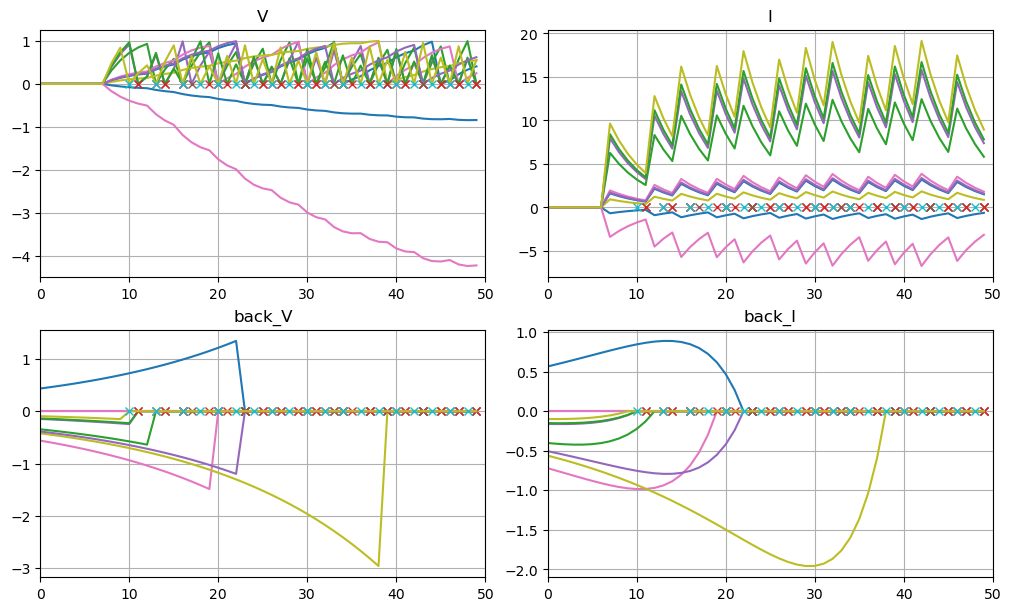

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
for ax, data, title in zip(axs.T.flatten(), [V, lV, I, lI], ["V", "back_V", "I", "back_I"]) : 
    for n in range(dims[-1]) : 
        ax.plot(data[:, 0, n].cpu().data.numpy(), label=f"neuron {n}")
        ax.plot(spike_times[n], np.zeros_like(spike_times[n]), "x", label=f"spike {n}")
    ax.set_title(title)
    ax.grid(visible=True)
    ax.set_xlim(0, timesteps)

In [21]:
{
    n : I[..., n][times - 1][:1] for n, times in spike_times.items()
}

{0: tensor([[3.0077]], grad_fn=<SliceBackward0>),
 1: tensor([[8.3222]], grad_fn=<SliceBackward0>),
 2: tensor([[4.0719]], grad_fn=<SliceBackward0>),
 3: tensor([[3.2822]], grad_fn=<SliceBackward0>),
 4: tensor([[1.0703]], grad_fn=<SliceBackward0>),
 5: tensor([], size=(0, 1), grad_fn=<SliceBackward0>),
 6: tensor([[4.3080]], grad_fn=<SliceBackward0>),
 7: tensor([[3.1674]], grad_fn=<SliceBackward0>),
 8: tensor([], size=(0, 1), grad_fn=<SliceBackward0>),
 9: tensor([[6.1695]], grad_fn=<SliceBackward0>)}

In [18]:
{n : I[spike_times[n]  , 0, n].cpu().data.numpy() for n in range(dims[1])}

{0: array([2.406131 , 2.0385292, 1.6405836], dtype=float32)}

In [19]:
{n : V[spike_times[n] - 1, 0, n].cpu().data.numpy() for n in range(dims[1])}

{0: array([0.9429656, 0.955275 , 0.9814976], dtype=float32)}